In [1]:
import jax
import jax.numpy as np

from numpy.polynomial.hermite import hermgauss

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils, plotting_utils
from structure_vb_lib.structure_optimization_lib import optimize_structure

from bnpmodeling_runjingdev import result_loading_utils
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
seed = 98765
onp.random.seed(seed)

# Load data

In [3]:
g_obs, _, labels, _ = data_utils.load_thrush_data()

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [4]:
print(g_obs.shape)

(155, 7, 2, 21)


In [5]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]

In [6]:
onp.unique(labels)

array(['Chawia', 'Mbololo', 'Ngangao', 'Yale'], dtype='<U32')

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params(n_allele)

alpha0 = 3.0
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': 3.0, 'allele_prior_lambda_vec': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1.], dtype=float64)}


# Get VB params 

In [8]:
k_approx = 20

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs = n_obs,
                                                      n_loci = n_loci,
                                                      n_allele = n_allele, 
                                                      k_approx = k_approx, 
                                                      prng_key = jax.random.PRNGKey(seed))
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (20, 7, 21) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 19) (lb=0.0, ub=inf)


# Optimize

In [11]:
vb_opt_dict, vb_opt, ez_opt, out, _ = \
    optimize_structure(g_obs,
                      vb_params_dict,
                      vb_params_paragami,
                      prior_params_dict, 
                      gh_loc, 
                      gh_weights)

compiling objective and derivatives ... 
done. Compile time: 45.158sec
Running L-BFGS-B ...
L-BFGS-B time: 6.088sec
BFGS out:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Running trust-ncg ... 
Newton time: 3.959sec
Newton out:  Optimization terminated successfully.
done. 


In [12]:
vb_dict_tmp = paragami.load_folded('../fits/thrush_fits/thrush_fit_alpha3.0.npz')[0]
np.abs(vb_params_paragami.flatten(vb_dict_tmp, free = True) -vb_opt).max()

DeviceArray(1.11022302e-16, dtype=float64)

# Check out the fit

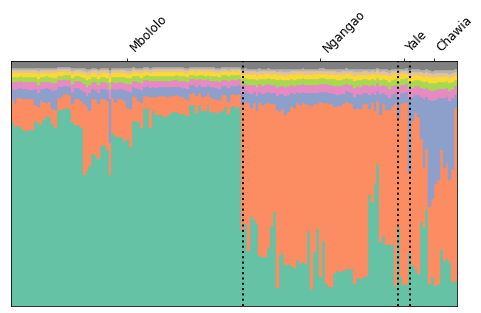

In [13]:
e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

# sort everything within populations
perm_obs = data_utils.cluster_admix_get_indx_within_labels(onp.array(e_ind_admix),
                                                               labels)

# now re-order populations: put chawia last
_labels = deepcopy(labels)
_labels[_labels == 'Chawia'] = 'z'
perm2 = onp.argsort(_labels)
perm_obs = perm_obs[perm2]

# plot admixture
fig, ax = plt.subplots(1, 1, figsize = (8, 4.5))

plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                 ax,
                                 8, 
                                 cmap_colors = plt.get_cmap('Set2').colors);

# print labels
plotting_utils.draw_region_separation(labels[perm2], ax);

In [14]:
coclust = np.dot(e_ind_admix[perm_obs], 
                 e_ind_admix[perm_obs].transpose())

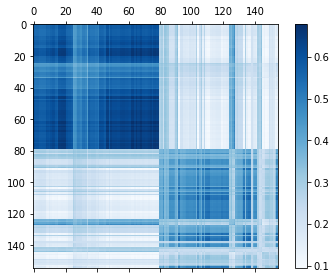

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4.5))

im0 = ax.matshow(coclust, 
                 cmap = plt.get_cmap('Blues'))

fig.colorbar(im0, ax = ax)

In [16]:
e_num_loci_per_cluster = posterior_quantities_lib.get_e_num_loci_per_cluster(g_obs, vb_opt_dict, gh_loc, gh_weights)
e_num_ind_per_cluster = posterior_quantities_lib.get_e_num_ind_per_cluster(vb_opt_dict, gh_loc, gh_weights)

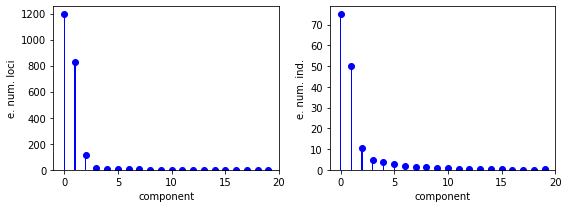

In [17]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

result_loading_utils._plot_weights(e_num_loci_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(e_num_ind_per_cluster, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. loci')
axarr[1].set_ylabel('e. num. ind.')
    
fig.tight_layout()

# Define sensitivity object

In [18]:
# initial prior alpha
use_free_alpha = True
hyper_param0 = prior_params_paragami['dp_prior_alpha'].flatten(alpha0, 
                                                              free = use_free_alpha)

In [19]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, 
                          vb_params_dict,
                          _prior_params_dict,
                          gh_loc, 
                          gh_weights).squeeze()


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])

### The sensitivity object

In [20]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        hyper_param0)

Compiling hessian solver ...
Hessian solver compile time: 70.6841sec

Compiling cross hessian...
Cross-hessian compile time: 0.588235sec

LR sensitivity time: 0.32906sec



# Fit for a range of alpha

In [21]:
alpha_list = np.arange(1, 15, dtype = float)

### Define loss as function of free params and alpha
and we precompile its derivatives beforehand

In [22]:
get_fun = jax.jit(objective_fun_free)

get_grad = jax.jit(jax.grad(objective_fun_free, argnums = 0))

def _get_hvp(x, hyper_param0, v):
    return jax.jvp(jax.grad(objective_fun_free, argnums = 0), (x, hyper_param0), (v, 0.))[1]

get_hvp = jax.jit(_get_hvp)

In [23]:
# compile ... 
_ = get_fun(vb_opt, hyper_param0).block_until_ready()
_ = get_grad(vb_opt, hyper_param0).block_until_ready()
_ = get_hvp(vb_opt, hyper_param0, vb_opt).block_until_ready()

In [24]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    hyper_param0 = prior_params_paragami['dp_prior_alpha'].flatten(alpha, free = use_free_alpha)
    
    vb_opt_pert = optimize_kl(lambda x : get_fun(x, hyper_param0),
                             new_init_dict, 
                             vb_params_paragami, 
                             get_grad = lambda x : get_grad(x, hyper_param0),
                             get_hvp = lambda x, v: get_hvp(x, hyper_param0, v),
                             run_lbfgs = False,
                             run_newton = True)[1]                             
        
    return vb_opt_pert

In [25]:
refit_list = []

new_init_dict = deepcopy(vb_opt_dict)

for alpha in alpha_list: 
    print('\n################')
    print('re-optimzing with alpha = ', alpha)
    print('################')
    
    refit_list.append(refit_with_alpha(alpha, new_init_dict))


################
re-optimzing with alpha =  1.0
################
compiling objective and derivatives ... 
done. Compile time: 2.938sec
Running trust-ncg ... 
Newton time: 10.642sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  2.0
################
compiling objective and derivatives ... 
done. Compile time: 2.833sec
Running trust-ncg ... 
Newton time: 5.921sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  3.0
################
compiling objective and derivatives ... 
done. Compile time: 2.829sec
Running trust-ncg ... 
Newton time: 0.032sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  4.0
################
compiling objective and derivatives ... 
done. Compile time: 2.833sec
Running trust-ncg ... 
Newton time: 6.559sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =

# Get linear response predictions

In [26]:
lr_list = []

for alpha in alpha_list: 
    
    hyper_param_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha, free = use_free_alpha)
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(hyper_param_pert))

# Check free parameters

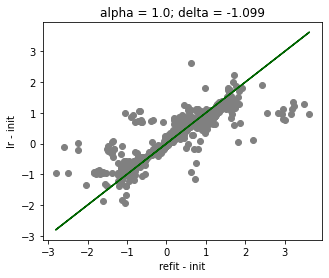

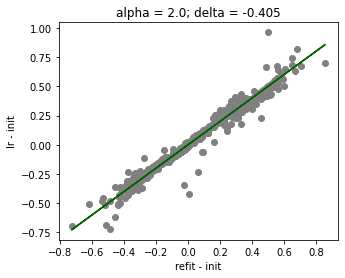

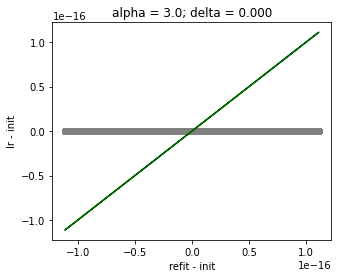

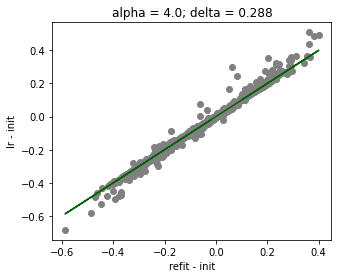

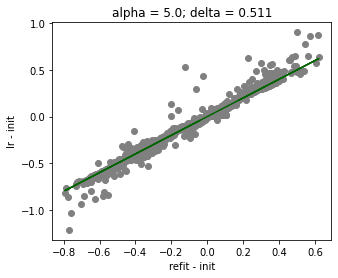

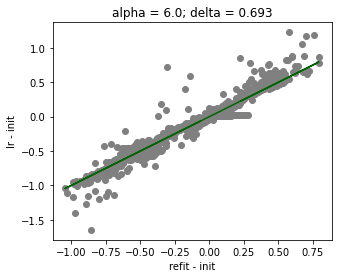

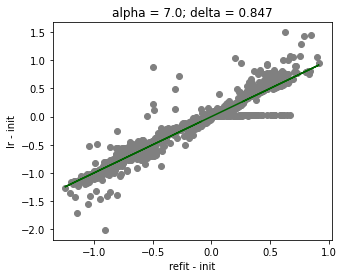

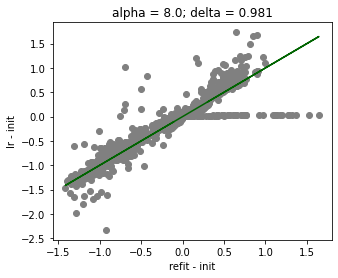

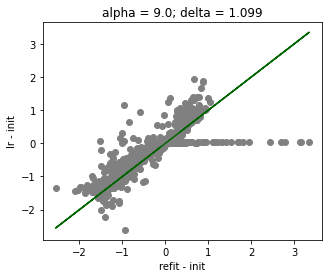

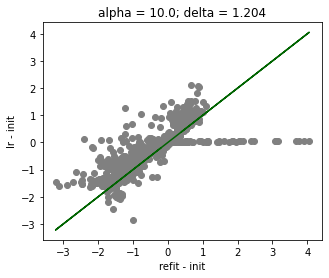

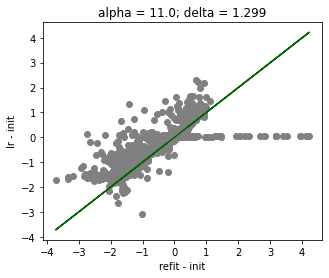

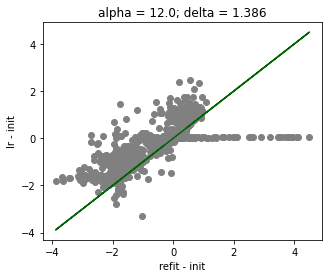

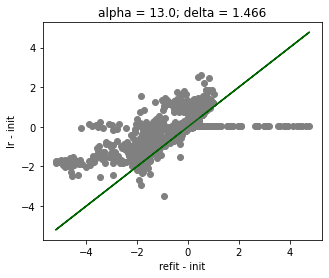

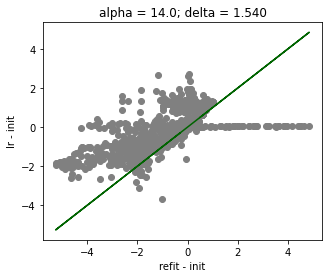

In [27]:
for i in range(len(alpha_list)): 
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    result_loading_utils.print_diff_plot(refit_list[i], 
                                         lr_list[i],
                                         vb_opt,
                                         ax, 
                                         alpha = 1.)
    
    alpha = alpha_list[i]
    hyper_param_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha,
                                                                       free = use_free_alpha)
    delta = hyper_param_pert - hyper_param0
    plt.title('alpha = ' + str(alpha) + '; delta = {:.03f}'.format(delta[0]))
    

# Number of clusters

In [28]:
prng_key = jax.random.PRNGKey(223)

@jax.jit
def get_n_clusters_insample(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs,
                                                       vb_params_dict,
                                                       gh_loc,
                                                       gh_weights,
                                                       threshold = 0,
                                                       n_samples = 10000, 
                                                       prng_key = prng_key)

@jax.jit
def get_n_clusters_pred(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                            gh_loc, 
                                                            gh_weights, 
                                                            threshold = 0,
                                                            prng_key = prng_key)

In [29]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
title_fontsize = 20

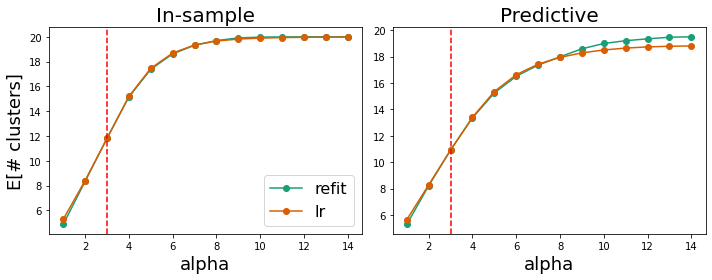

In [30]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# in sample number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[0])
axarr[0].legend()
axarr[0].set_title('In-sample', fontsize = title_fontsize)
axarr[0].set_ylabel('E[# clusters]')

# predictive number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[1])

axarr[1].set_title('Predictive', fontsize = title_fontsize)

for i in range(2):
    axarr[i].axvline(alpha0, 
                     color = 'red', 
                     linestyle = '--')
    axarr[i].set_xlabel('alpha')
    


fig.tight_layout()
fig.savefig('../../writing/notes_for_tamara/figures/structure_alpha_e_num_clusters.png')

### Thresholded

In [31]:
prng_key = jax.random.PRNGKey(223)

threshold1 = np.ceil((n_obs * n_loci * 2) * 0.01)
threshold2 = np.ceil(n_obs * 0.01)

print(threshold1)
print(threshold2)

@jax.jit
def get_n_clusters_insample_thresh(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs,
                                                            vb_params_dict,
                                                            gh_loc, gh_weights,
                                                            threshold = threshold1,
                                                            n_samples = 1000, 
                                                            prng_key = prng_key)

@jax.jit
def get_n_clusters_pred_thresh(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                            gh_loc, 
                                                            gh_weights, 
                                                            n_samples = 1000,
                                                            threshold = threshold2,
                                                            prng_key = prng_key)

22.0
2.0


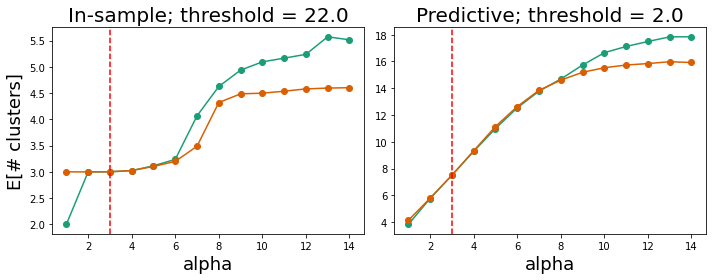

In [32]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# in sample number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample_thresh, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[0])
# axarr[0].legend()
axarr[0].set_title('In-sample; threshold = {}'.format(threshold1), fontsize = title_fontsize)
axarr[0].set_ylabel('E[# clusters]')

# predictive number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred_thresh,
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[1])
axarr[1].set_title('Predictive; threshold = {}'.format(threshold2), fontsize = title_fontsize)

for i in range(2):
    axarr[i].axvline(alpha0, 
                     color = 'red', 
                     linestyle = '--')
    axarr[i].set_xlabel('alpha')
    # axarr[i].set_ylabel('E[# clusters]')

fig.tight_layout()

fig.savefig('../../writing/notes_for_tamara/figures/structure_alpha_e_num_clusters_thresh.png')

# Cluster weights

In [33]:
def get_cluster_weights(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_loci_per_cluster(g_obs, vb_params_dict, gh_loc, gh_weights)
#     return posterior_quantities_lib.get_e_num_ind_per_cluster(vb_params_dict, gh_loc, gh_weights)

In [34]:
def plot_e_num_obs_trace(): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_cluster_weights, refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_cluster_weights, lr_list)
    
        
    fig, ax = plt.subplots(2, 4, figsize = (16, 6), sharex = True) 
    
    for k in range(8): 
        x0 = k // 4
        x1 = k % 4
        ax[x0, x1].plot(alpha_list, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[x0, x1].plot(alpha_list, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[x0, x1].set_title('k = {}'.format(k), fontsize = title_fontsize)
        ax[x0, x1].axvline(alpha0, 
                           color = 'red', 
                           linestyle = '--')
        
        
        if k == 0: 
            ax[x0, x1].legend()
            
    for k in range(4): 
        ax[-1, k].set_xlabel('alpha')
        
    for k in range(2): 
        ax[k, 0].set_ylabel('E(# loci)')
    
    fig.tight_layout()


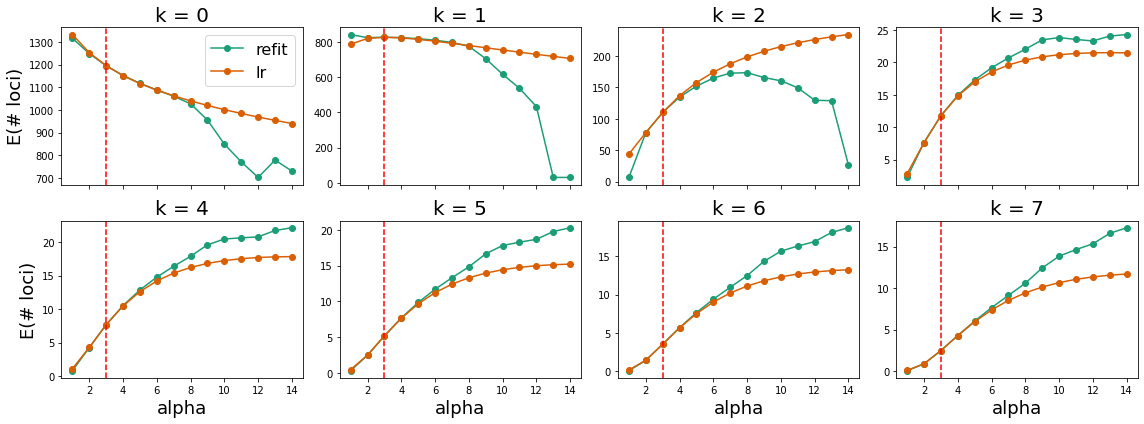

In [35]:
plot_e_num_obs_trace()

# Coclustering

In [36]:
@jax.jit
def get_coclustering(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, 
                                             free = True)
    
    e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0][perm_obs]
    
    return np.dot(e_ind_admix, e_ind_admix.transpose())

In [37]:
def get_coclust_mean_abs_diff(vb_params_free): 
    init_coclust = get_coclustering(vb_opt)
    pert_coclust = get_coclustering(vb_params_free) 
    
    return np.abs(pert_coclust - init_coclust).mean()

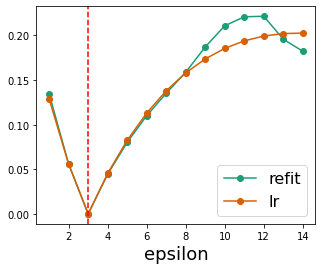

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (5, 4))

result_loading_utils.plot_post_stat_per_epsilon(get_coclust_mean_abs_diff, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               ax)
ax.axvline(alpha0, 
           color = 'red', 
           linestyle = '--')

ax.legend()

In [39]:
def plot_coclustering_at_alpha(alpha_pert, fig, axarr): 
    
    alpha_indx = np.argwhere(alpha_list == alpha_pert).squeeze()
    
    coclust_init = get_coclustering(vb_opt)
    coclust_lr = get_coclustering(lr_list[alpha_indx])
    coclust_refit = get_coclustering(refit_list[alpha_indx])
    
    result_loading_utils.plot_colormaps(coclust_refit,
                                   coclust_lr,
                                   coclust_init,
                                   fig,
                                   axarr, 
                                   plot_initial = False)
    
    return coclust_init, coclust_lr, coclust_refit

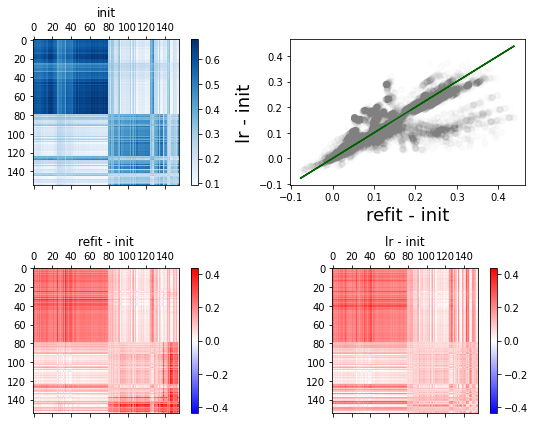

In [40]:
alpha_pert = 1

fig, axarr = plt.subplots(2, 2, figsize = (8, 6))

###############
# Get and plot co-clustering matrices
###############
coclust_init, coclust_lr, coclust_refit = plot_coclustering_at_alpha(alpha_pert, fig, axarr[1])

################
# initial co-clustering matrix
################
im0 = axarr[0, 0].matshow(coclust_init, 
                 cmap = plt.get_cmap('Blues'))
axarr[0, 0].set_title('init')
fig.colorbar(im0, ax = axarr[0, 0])

################
# differences
################
result_loading_utils.print_diff_plot(coclust_refit.flatten(),
                                     coclust_lr.flatten(), 
                                    coclust_init.flatten(), 
                                    axarr[0, 1], 
                                    alpha = 0.01)

fig.tight_layout()

# figures for meeting w tamara

In [41]:
def plot_e_num_obs_trace2(): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_cluster_weights, refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_cluster_weights, lr_list)
    
        
    fig, ax = plt.subplots(1, 4, figsize = (16, 4), sharex = True) 
    
    for k in range(4): 
        ax[k].plot(alpha_list, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[k].plot(alpha_list, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[k].set_title('k = {}'.format(k), fontsize = title_fontsize)
        ax[k].axvline(alpha0, 
                           color = 'red', 
                           linestyle = '--')
        
    ax[0].legend()
    ax[0].set_ylabel('E(# loci)')
    
            
    for k in range(4): 
        ax[k].set_xlabel('alpha')
        
    fig.tight_layout()
    
    fig.savefig('../../writing/notes_for_tamara/figures/structure_alpha_mixture_weights.png')

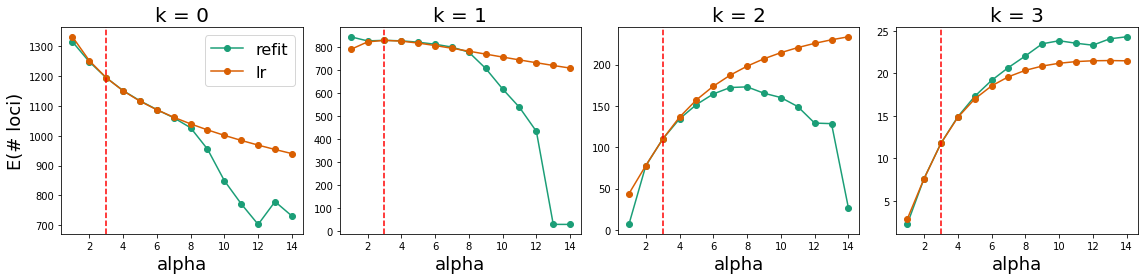

In [42]:
plot_e_num_obs_trace2()

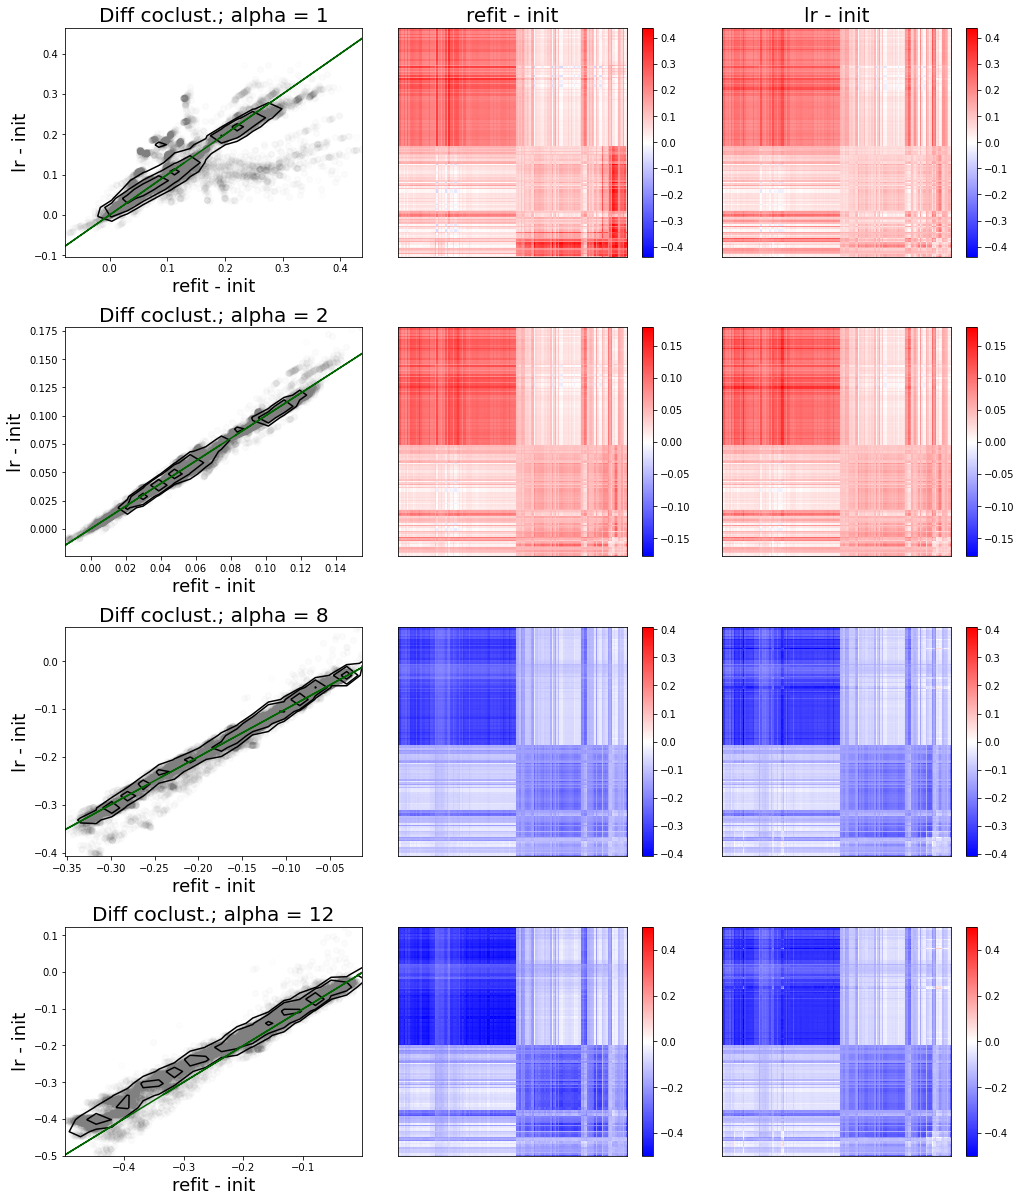

In [45]:
fig, axarr = plt.subplots(4, 3, figsize = (12 * 1.2, 14 * 1.2)) 

alpha_pert_vec = [1, 2, 8, 12]

for k in range(len(alpha_pert_vec)):
    
    # plot diff co-clustering matricies
    coclust_init, coclust_lr, coclust_refit = \
        plot_coclustering_at_alpha(alpha_pert_vec[k],
                                   fig,
                                   axarr[k, 1:3]);
    
    
    # print diff plot
    result_loading_utils.print_diff_plot(coclust_refit.flatten(),
                                     coclust_lr.flatten(), 
                                    coclust_init.flatten(), 
                                    axarr[k, 0], 
                                    alpha = 0.01, 
                                    plot_contours = True)
    
axarr[0, 1].set_title('refit - init', fontsize = title_fontsize)
axarr[0, 2].set_title('lr - init', fontsize = title_fontsize)
    
for k in range(4): 
    
    axarr[k, 1].set_title('', fontsize = title_fontsize)
    axarr[k, 2].set_title('', fontsize = title_fontsize)
    
    axarr[k, 1].set_xticks([])
    axarr[k, 1].set_yticks([])
    
    axarr[k, 2].set_xticks([])
    axarr[k, 2].set_yticks([])
    
    axarr[k, 0].set_title('Diff coclust.; alpha = {}'.format(alpha_pert_vec[k]), 
                          fontsize = title_fontsize)

axarr[0, 1].set_title('refit - init', fontsize = title_fontsize)
axarr[0, 2].set_title('lr - init', fontsize = title_fontsize)

fig.tight_layout();

fig.savefig('../../writing/notes_for_tamara/figures/structure_alpha_coclust.png')